In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your data
df = pd.read_csv("/Users/difa/Desktop/round-1-island-data-bottle/prices_round_1_day_-2.csv")
df = df.iloc[:, 0].str.split(";", expand=True)

df.columns = [
    "day", "timestamp", "product",
    "bid_price_1", "bid_volume_1", "bid_price_2", "bid_volume_2", "bid_price_3", "bid_volume_3",
    "ask_price_1", "ask_volume_1", "ask_price_2", "ask_volume_2", "ask_price_3", "ask_volume_3",
    "mid_price", "profit_and_loss"
]

# Convert numeric columns
for col in df.columns[3:]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Filter for Rainforest
resin = df[df["product"] == "RAINFOREST_RESIN"].copy()
resin.reset_index(drop=True, inplace=True)


In [30]:
df

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,-2,0,RAINFOREST_RESIN,9996,1,9995.0,25.0,NaN,NaN,10004,1,10005.0,25.0,NaN,NaN,10000.0,0.0
1,-2,0,KELP,1998,26,NaN,NaN,NaN,NaN,2002,26,NaN,NaN,NaN,NaN,2000.0,0.0
2,-2,0,SQUID_INK,1998,26,NaN,NaN,NaN,NaN,2002,26,NaN,NaN,NaN,NaN,2000.0,0.0
3,-2,100,SQUID_INK,1999,5,1998.0,26.0,NaN,NaN,2001,20,NaN,NaN,NaN,NaN,2000.0,0.0
4,-2,100,RAINFOREST_RESIN,10000,5,9995.0,20.0,NaN,NaN,10005,20,NaN,NaN,NaN,NaN,10002.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,-2,999800,RAINFOREST_RESIN,9996,1,9995.0,25.0,NaN,NaN,9998,1,10002.0,9.0,10004.0,1.0,9997.0,0.0
29996,-2,999800,KELP,2026,26,NaN,NaN,NaN,NaN,2028,3,2030.0,26.0,NaN,NaN,2027.0,0.0
29997,-2,999900,RAINFOREST_RESIN,9996,2,9995.0,30.0,NaN,NaN,10004,2,10005.0,30.0,NaN,NaN,10000.0,0.0
29998,-2,999900,KELP,2027,4,2026.0,32.0,NaN,NaN,2029,32,NaN,NaN,NaN,NaN,2028.0,0.0


Spread stats:
count    10000.000000
mean         6.728800
std          2.508761
min          2.000000
25%          6.000000
50%          8.000000
75%          8.000000
max         10.000000
Name: spread, dtype: float64

Volatility stats:
count    9991.000000
mean        1.446855
std         0.427603
min         0.000000
25%         1.183216
50%         1.453922
75%         1.744834
max         2.869863
Name: volatility, dtype: float64


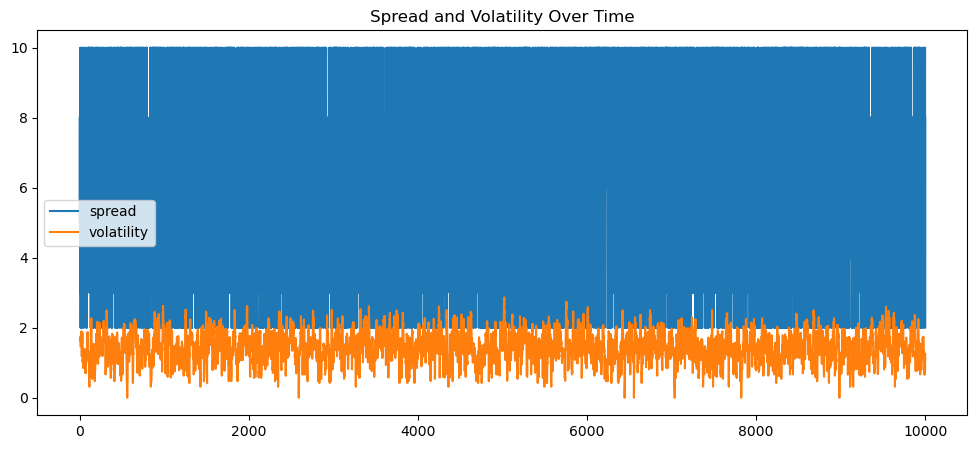

In [2]:
resin["spread"] = resin["ask_price_1"] - resin["bid_price_1"]
resin["volatility"] = resin["mid_price"].rolling(window=10).std()

print("Spread stats:")
print(resin["spread"].describe())

print("\nVolatility stats:")
print(resin["volatility"].describe())

# Plot (optional)
resin[["spread", "volatility"]].plot(title="Spread and Volatility Over Time", figsize=(12, 5))
plt.show()


Book Imbalance stats:
count    10000.000000
mean         0.003998
std          0.408531
min         -0.999999
25%          0.000000
50%          0.000000
75%          0.000000
max          0.935484
Name: book_imbalance, dtype: float64


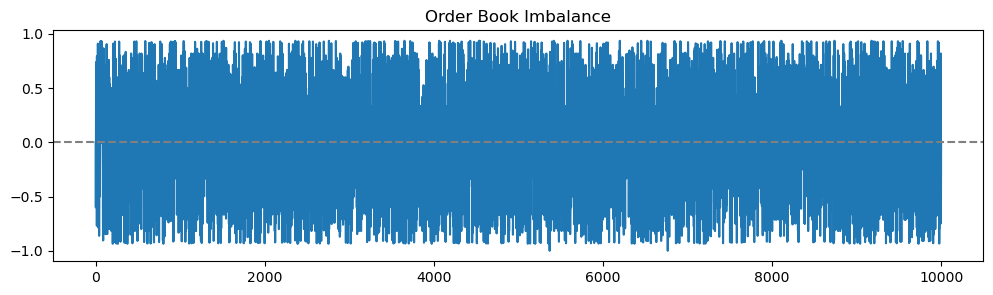

In [3]:
resin["book_imbalance"] = (
    resin["bid_volume_1"].fillna(0) - resin["ask_volume_1"].fillna(0)
) / (
    resin["bid_volume_1"].fillna(0) + resin["ask_volume_1"].fillna(0) + 1e-6
)

print("Book Imbalance stats:")
print(resin["book_imbalance"].describe())

# Plot
resin["book_imbalance"].plot(title="Order Book Imbalance", figsize=(12, 3))
plt.axhline(0, color="gray", linestyle="--")
plt.show()


In [4]:
resin["future_mid"] = resin["mid_price"].shift(-5)
resin["mid_return"] = resin["future_mid"] - resin["mid_price"]

# Correlation matrix
correlations = resin[["mid_return", "book_imbalance", "volatility", "spread"]].corr()
print("Correlation with future price movement:")
print(correlations["mid_return"])


Correlation with future price movement:
mid_return        1.000000
book_imbalance    0.165065
volatility        0.000601
spread            0.007121
Name: mid_return, dtype: float64


In [5]:
# Simulate basic MM strategy: quote 2 ticks inside spread
resin["bid_quote"] = resin["mid_price"] - 2
resin["ask_quote"] = resin["mid_price"] + 2

# Check if quote would be filled
resin["would_buy_fill"] = resin["bid_quote"] >= resin["ask_price_1"]
resin["would_sell_fill"] = resin["ask_quote"] <= resin["bid_price_1"]

fill_rate = resin[["would_buy_fill", "would_sell_fill"]].mean()
print("Estimated Fill Rates (aggressive 2-tick quote):")
print(fill_rate)


Estimated Fill Rates (aggressive 2-tick quote):
would_buy_fill     0.0
would_sell_fill    0.0
dtype: float64


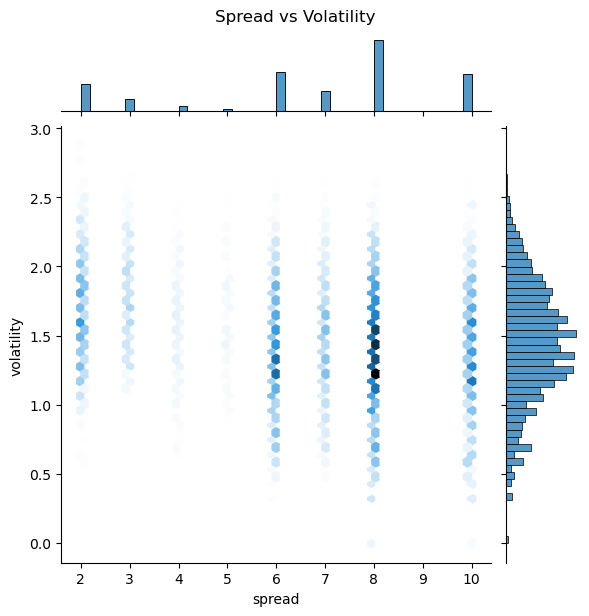

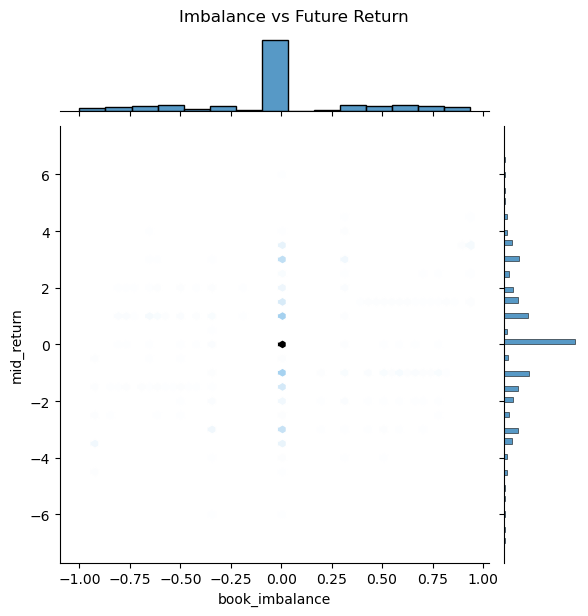

In [6]:
import seaborn as sns

# Heatmap of spread vs volatility
sns.jointplot(data=resin, x="spread", y="volatility", kind="hex", height=6)
plt.suptitle("Spread vs Volatility", y=1.02)
plt.show()

# Heatmap of imbalance vs return
sns.jointplot(data=resin, x="book_imbalance", y="mid_return", kind="hex", height=6)
plt.suptitle("Imbalance vs Future Return", y=1.02)
plt.show()



--- Analyzing RAINFOREST_RESIN ---

Spread stats:
count    10000.000000
mean         6.728800
std          2.508761
min          2.000000
25%          6.000000
50%          8.000000
75%          8.000000
max         10.000000
Name: spread, dtype: float64

Volatility stats:
count    9991.000000
mean        1.446855
std         0.427603
min         0.000000
25%         1.183216
50%         1.453922
75%         1.744834
max         2.869863
Name: volatility, dtype: float64

Book imbalance stats:
count    10000.000000
mean         0.003998
std          0.408531
min         -0.999999
25%          0.000000
50%          0.000000
75%          0.000000
max          0.935484
Name: book_imbalance, dtype: float64


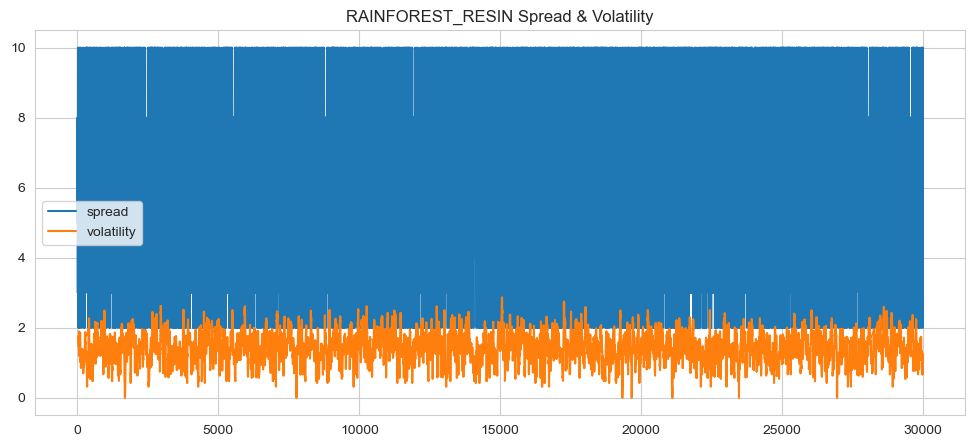

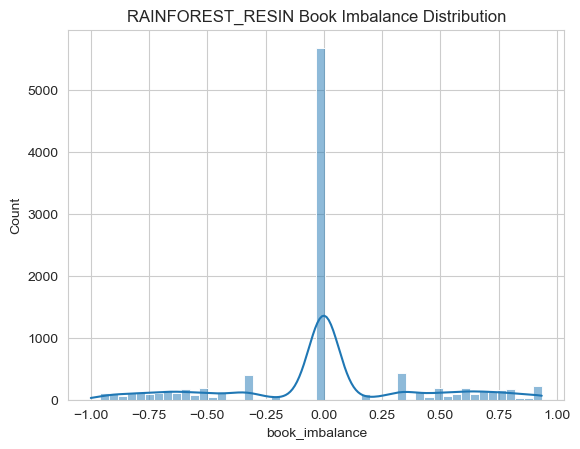


--- Analyzing KELP ---

Spread stats:
count    10000.000000
mean         2.692200
std          0.881781
min          1.000000
25%          2.000000
50%          3.000000
75%          3.000000
max          4.000000
Name: spread, dtype: float64

Volatility stats:
count    9991.000000
mean        0.557188
std         0.192167
min         0.000000
25%         0.421637
50%         0.550252
75%         0.677003
max         1.472903
Name: volatility, dtype: float64

Book imbalance stats:
count    10000.000000
mean         0.028279
std          0.514188
min         -0.939394
25%          0.000000
50%          0.000000
75%          0.121212
max          0.944444
Name: book_imbalance, dtype: float64


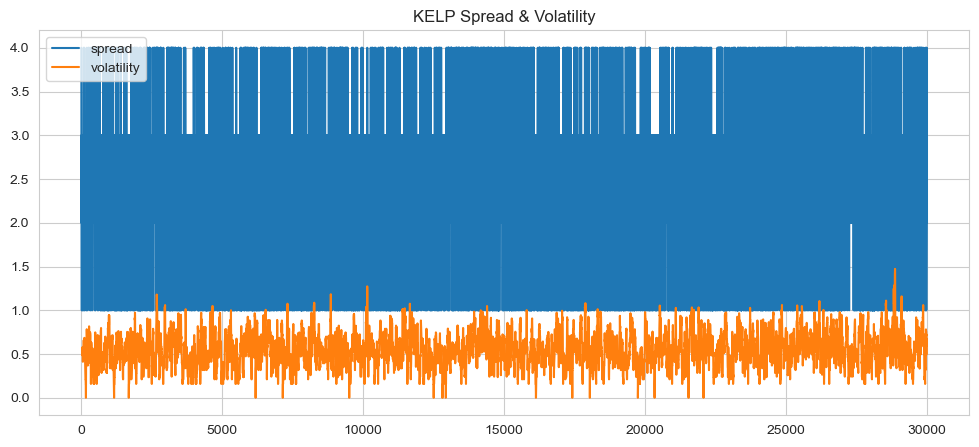

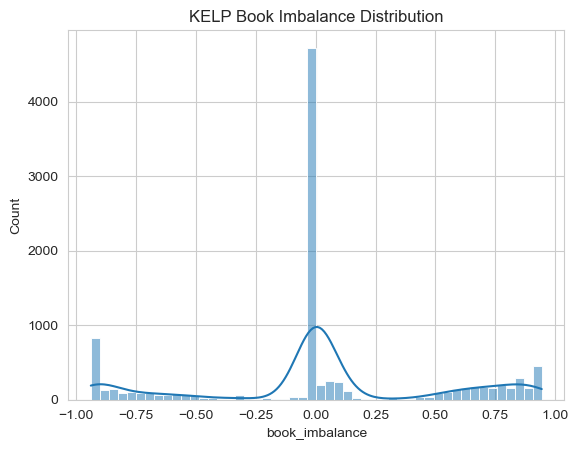


--- Analyzing SQUID_INK ---

Spread stats:
count    10000.000000
mean         2.717700
std          0.898269
min          1.000000
25%          2.000000
50%          3.000000
75%          3.000000
max          4.000000
Name: spread, dtype: float64

Volatility stats:
count    9991.000000
mean        1.768181
std         1.631472
min         0.210819
25%         0.973253
50%         1.349897
75%         1.972731
max        32.807731
Name: volatility, dtype: float64

Book imbalance stats:
count    10000.000000
mean         0.020847
std          0.517550
min         -0.939394
25%         -0.016393
50%          0.000000
75%          0.115385
max          0.944444
Name: book_imbalance, dtype: float64


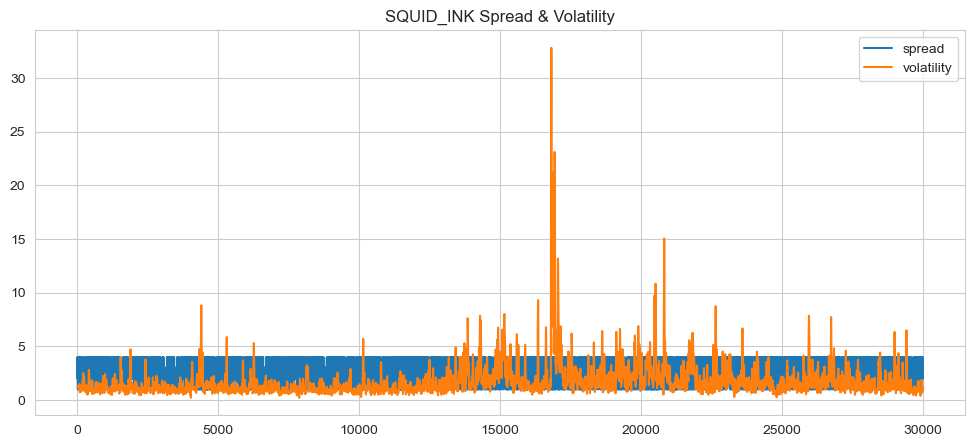

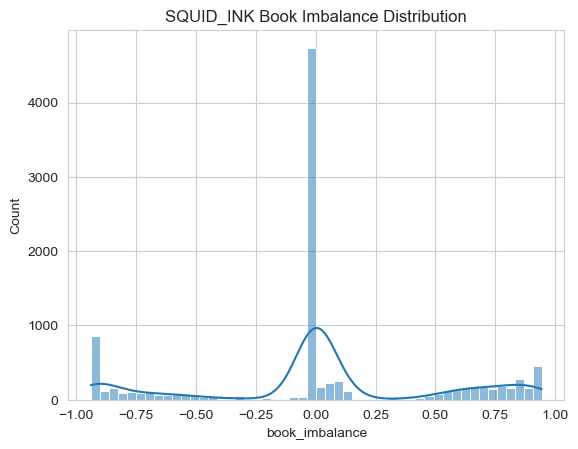

In [7]:
def analyze_product(data, product_name):
    print(f"\n--- Analyzing {product_name} ---")
    d = data[data["product"] == product_name].copy()
    d["spread"] = d["ask_price_1"] - d["bid_price_1"]
    d["volatility"] = d["mid_price"].rolling(10).std()
    d["book_imbalance"] = (
        d["bid_volume_1"].fillna(0) - d["ask_volume_1"].fillna(0)
    ) / (
        d["bid_volume_1"].fillna(0) + d["ask_volume_1"].fillna(0) + 1e-6
    )

    print("\nSpread stats:")
    print(d["spread"].describe())

    print("\nVolatility stats:")
    print(d["volatility"].describe())

    print("\nBook imbalance stats:")
    print(d["book_imbalance"].describe())

    sns.set_style("whitegrid")
    d[["spread", "volatility"]].plot(title=f"{product_name} Spread & Volatility", figsize=(12, 5))
    plt.show()

    sns.histplot(d["book_imbalance"], bins=50, kde=True)
    plt.title(f"{product_name} Book Imbalance Distribution")
    plt.show()

    return d

df_rain = analyze_product(df, "RAINFOREST_RESIN")
df_kelp = analyze_product(df, "KELP")
df_squid = analyze_product(df, "SQUID_INK")



RAINFOREST_RESIN - Correlation with Future Mid-Price Change (5 steps ahead):
mid_return        1.000000
book_imbalance    0.165065
volatility        0.000601
spread            0.007121
Name: mid_return, dtype: float64


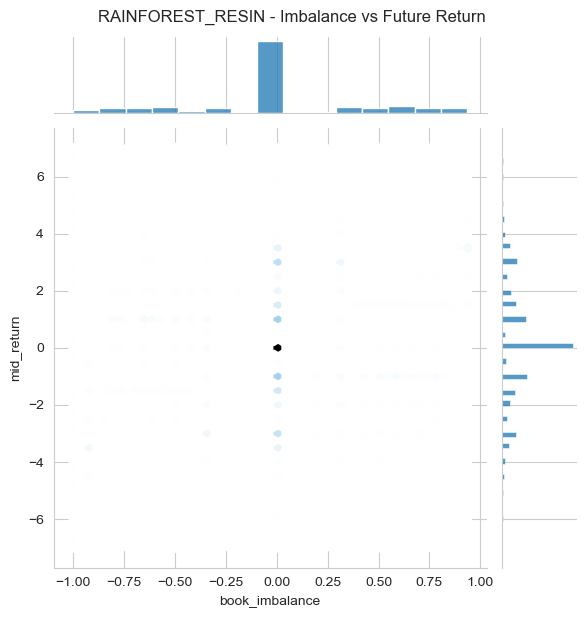


KELP - Correlation with Future Mid-Price Change (5 steps ahead):
mid_return        1.000000
book_imbalance    0.527379
volatility        0.032487
spread           -0.046724
Name: mid_return, dtype: float64


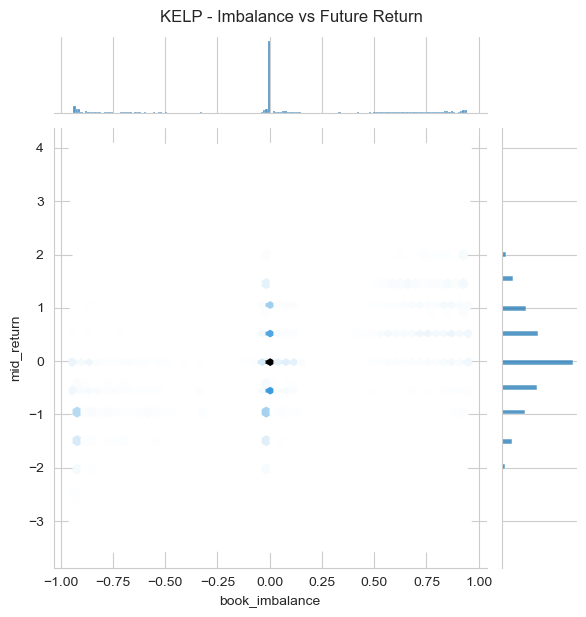


SQUID_INK - Correlation with Future Mid-Price Change (5 steps ahead):
mid_return        1.000000
book_imbalance    0.111693
volatility       -0.009373
spread           -0.007565
Name: mid_return, dtype: float64


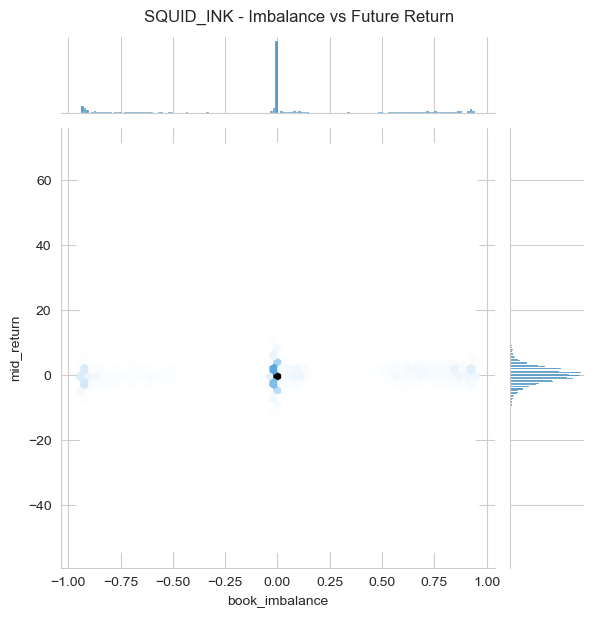

In [8]:
def predictive_signals(df_asset, name):
    df_asset["future_mid"] = df_asset["mid_price"].shift(-5)
    df_asset["mid_return"] = df_asset["future_mid"] - df_asset["mid_price"]

    corr = df_asset[["mid_return", "book_imbalance", "volatility", "spread"]].corr()
    print(f"\n{name} - Correlation with Future Mid-Price Change (5 steps ahead):")
    print(corr["mid_return"])

    sns.jointplot(data=df_asset, x="book_imbalance", y="mid_return", kind="hex", height=6)
    plt.suptitle(f"{name} - Imbalance vs Future Return", y=1.02)
    plt.show()

predictive_signals(df_rain, "RAINFOREST_RESIN")
predictive_signals(df_kelp, "KELP")
predictive_signals(df_squid, "SQUID_INK")


In [9]:
def fill_simulation(df_asset, name, edge=2):
    df_asset["bid_quote"] = df_asset["mid_price"] - edge
    df_asset["ask_quote"] = df_asset["mid_price"] + edge

    df_asset["would_buy_fill"] = df_asset["bid_quote"] >= df_asset["ask_price_1"]
    df_asset["would_sell_fill"] = df_asset["ask_quote"] <= df_asset["bid_price_1"]

    print(f"\n{name} Fill Rates (quote ±{edge} from mid):")
    print(df_asset[["would_buy_fill", "would_sell_fill"]].mean())

fill_simulation(df_rain, "RAINFOREST_RESIN", edge=2)
fill_simulation(df_kelp, "KELP", edge=2)
fill_simulation(df_squid, "SQUID_INK", edge=2)



RAINFOREST_RESIN Fill Rates (quote ±2 from mid):
would_buy_fill     0.0
would_sell_fill    0.0
dtype: float64

KELP Fill Rates (quote ±2 from mid):
would_buy_fill     0.0
would_sell_fill    0.0
dtype: float64

SQUID_INK Fill Rates (quote ±2 from mid):
would_buy_fill     0.0
would_sell_fill    0.0
dtype: float64


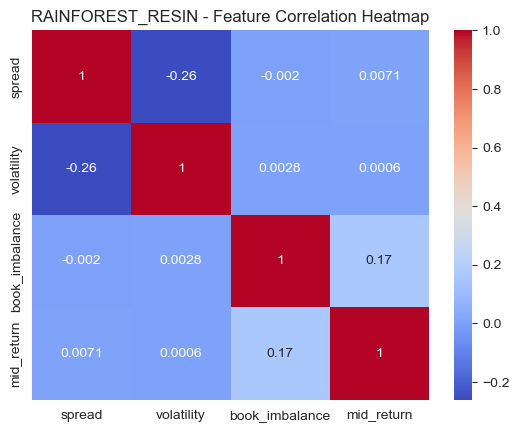

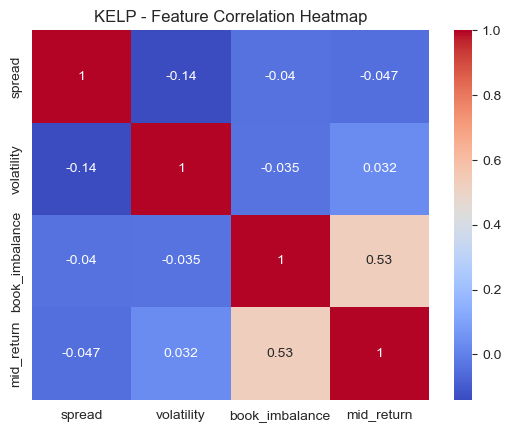

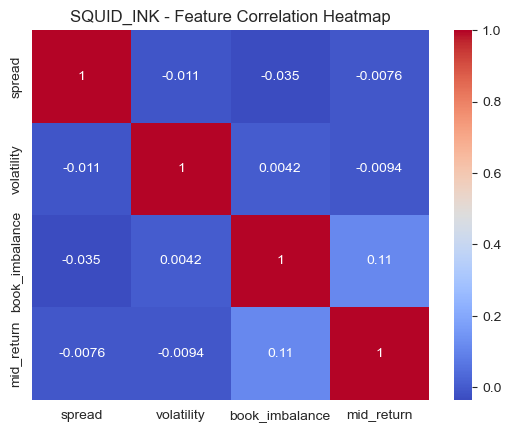

In [10]:
def quote_heatmap(df_asset, name):
    df_asset["future_mid"] = df_asset["mid_price"].shift(-5)
    df_asset["mid_return"] = df_asset["future_mid"] - df_asset["mid_price"]

    sns.heatmap(
        df_asset[["spread", "volatility", "book_imbalance", "mid_return"]].corr(),
        annot=True, cmap="coolwarm"
    )
    plt.title(f"{name} - Feature Correlation Heatmap")
    plt.show()

quote_heatmap(df_rain, "RAINFOREST_RESIN")
quote_heatmap(df_kelp, "KELP")
quote_heatmap(df_squid, "SQUID_INK")


In [11]:
# Group assets into a dictionary
assets = ["RAINFOREST_RESIN", "KELP", "SQUID_INK"]
dfs = {asset: df[df["product"] == asset].copy().reset_index(drop=True) for asset in assets}

# Compute mid-price returns (use % change for comparability)
for name, d in dfs.items():
    d["mid_return"] = d["mid_price"].pct_change()
    d["volatility"] = d["mid_price"].rolling(10).std()
    d["timestamp"] = pd.to_numeric(d["timestamp"])

# Merge on timestamp
combined = dfs["RAINFOREST_RESIN"][["timestamp", "mid_return"]].rename(columns={"mid_return": "rain_return"})

for asset in ["KELP", "SQUID_INK"]:
    combined = combined.merge(
        dfs[asset][["timestamp", "mid_return"]].rename(columns={"mid_return": f"{asset.lower()}_return"}),
        on="timestamp", how="inner"
    )
combined.dropna(inplace=True)


In [12]:
# Create lagged versions of KELP/SQUID returns
for lag in range(1, 6):
    combined[f"kelp_lag_{lag}"] = combined["kelp_return"].shift(lag)
    combined[f"squid_lag_{lag}"] = combined["squid_ink_return"].shift(lag)

# Correlation matrix with lagged values
print("\n🔁 Correlation with Rainforest Return:")
print(combined.corr()["rain_return"].sort_values(ascending=False))



🔁 Correlation with Rainforest Return:
rain_return         1.000000
kelp_return         0.096842
squid_ink_return    0.033412
squid_lag_2         0.006260
kelp_lag_2          0.005732
squid_lag_5         0.002574
kelp_lag_5          0.001864
kelp_lag_3          0.001372
squid_lag_3         0.000488
timestamp          -0.000002
squid_lag_4        -0.004403
kelp_lag_4         -0.008297
squid_lag_1        -0.014876
kelp_lag_1         -0.051121
Name: rain_return, dtype: float64


In [13]:
from sklearn.linear_model import LinearRegression

# Predict rainforest returns using lagged other-asset returns
features = [col for col in combined.columns if "lag" in col]
X = combined[features].dropna()
y = combined.loc[X.index, "rain_return"]

model = LinearRegression().fit(X, y)
r2 = model.score(X, y)

print(f"R² of regression predicting Rainforest returns from lagged KELP/SQUID_INK: {r2:.4f}")
print("Feature coefficients:")
for f, c in zip(features, model.coef_):
    print(f"{f}: {c:.5f}")


R² of regression predicting Rainforest returns from lagged KELP/SQUID_INK: 0.0037
Feature coefficients:
kelp_lag_1: -0.03996
squid_lag_1: 0.00010
kelp_lag_2: -0.02574
squid_lag_2: 0.00079
kelp_lag_3: -0.01979
squid_lag_3: -0.00003
kelp_lag_4: -0.01801
squid_lag_4: -0.00040
kelp_lag_5: -0.00891
squid_lag_5: 0.00063


In [14]:
# Try: if KELP and SQUID move in the same direction, does Rainforest follow?
combined["agreement"] = (
    np.sign(combined["kelp_return"]) == np.sign(combined["squid_ink_return"])
)

# Average Rainforest return when there's agreement vs no agreement
print("\n🌐 Rainforest return conditional on cross-asset agreement:")
print(combined.groupby("agreement")["rain_return"].describe())



🌐 Rainforest return conditional on cross-asset agreement:
            count          mean       std     min     25%  50%     75%     max
agreement                                                                     
False      5134.0  3.727448e-07  0.000212 -0.0007 -0.0001  0.0  0.0001  0.0007
True       4865.0 -3.466702e-07  0.000214 -0.0007 -0.0001  0.0  0.0001  0.0007


In [26]:
import pandas as pd
import numpy as np

# Load raw file
df_raw = pd.read_csv("/Users/difa/Desktop/round-1-island-data-bottle/prices_round_1_day_-2.csv")
df = df_raw.iloc[:, 0].str.split(";", expand=True)

# Rename columns
df.columns = [
    "day", "timestamp", "product",
    "bid_price_1", "bid_volume_1", "bid_price_2", "bid_volume_2", "bid_price_3", "bid_volume_3",
    "ask_price_1", "ask_volume_1", "ask_price_2", "ask_volume_2", "ask_price_3", "ask_volume_3",
    "mid_price", "profit_and_loss"
]

# Convert columns
df["timestamp"] = pd.to_numeric(df["timestamp"])
for col in df.columns[3:]:
    df[col] = pd.to_numeric(df[col], errors="coerce")


In [27]:
def compute_features(df_product):
    df = df_product.copy()
    df["spread"] = df["ask_price_1"] - df["bid_price_1"]
    df["imbalance"] = (
        df["bid_volume_1"].fillna(0) - df["ask_volume_1"].fillna(0)
    ) / (df["bid_volume_1"].fillna(0) + df["ask_volume_1"].fillna(0) + 1e-6)
    df["return_1"] = df["mid_price"].pct_change()
    df["volatility_5"] = df["mid_price"].rolling(5).std()
    df["future_mid"] = df["mid_price"].shift(-5)
    df["target_return"] = df["future_mid"] - df["mid_price"]
    df["direction"] = (df["target_return"] > 0).astype(int)
    return df[["timestamp", "product", "mid_price", "spread", "imbalance", "return_1", "volatility_5", "target_return", "direction"]]


In [28]:
# Process each product
dfs = [compute_features(df[df["product"] == prod]) for prod in ["RAINFOREST_RESIN", "KELP", "SQUID_INK"]]
df_feat = pd.concat(dfs)

# Pivot by product
pivoted = df_feat.pivot(index="timestamp", columns="product")
pivoted.columns = ['_'.join(col).lower() for col in pivoted.columns]
pivoted.dropna(inplace=True)

# Reset index for modeling
ml_data = pivoted.reset_index()


In [19]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Predict rainforest direction
features = [
    "spread_rainforest_resin", "imbalance_rainforest_resin", "return_1_rainforest_resin",
    "volatility_5_rainforest_resin",
    "spread_kelp", "imbalance_kelp", "return_1_kelp", "volatility_5_kelp",
    "spread_squid_ink", "imbalance_squid_ink", "return_1_squid_ink", "volatility_5_squid_ink"
]

X = ml_data[features]
y = ml_data["direction_rainforest_resin"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = LGBMClassifier(n_estimators=100, max_depth=4, learning_rate=0.1)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


[LightGBM] [Info] Number of positive: 2809, number of negative: 5183
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2134
[LightGBM] [Info] Number of data points in the train set: 7992, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.351476 -> initscore=-0.612555
[LightGBM] [Info] Start training from score -0.612555
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

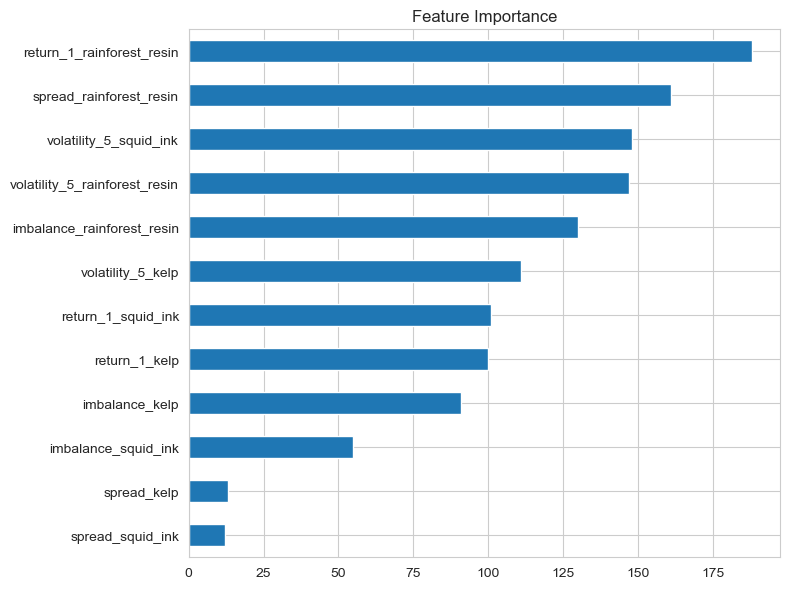

In [20]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp.plot(kind='barh', figsize=(8,6), title="Feature Importance")
plt.tight_layout()
plt.show()


In [21]:
# For a live tick (example: row from ml_data)
latest = ml_data.iloc[-1]
x_live = latest[features].values.reshape(1, -1)
prob = model.predict_proba(x_live)[0][1]

if prob > 0.6:
    print("🔼 BUY Rainforest Resin")
elif prob < 0.4:
    print("🔽 SELL Rainforest Resin")
else:
    print("⏸️ HOLD")


🔽 SELL Rainforest Resin


In [22]:
import joblib
joblib.dump(model, "rainforest_model.pkl")


['rainforest_model.pkl']

In [29]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import joblib

# Load dataset (after full feature engineering as shown earlier)
ml_data = ml_data

# Features
features = [
    "spread_rainforest_resin", "imbalance_rainforest_resin", "return_1_rainforest_resin", "volatility_5_rainforest_resin",
    "spread_kelp", "imbalance_kelp", "return_1_kelp", "volatility_5_kelp",
    "spread_squid_ink", "imbalance_squid_ink", "return_1_squid_ink", "volatility_5_squid_ink"
]

X = ml_data[features]
y = ml_data["target_return_rainforest_resin"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Fit model
model = LGBMRegressor(n_estimators=100, max_depth=4, learning_rate=0.1)
model.fit(X_train, y_train)

# Save model
joblib.dump(model, "rainforest_return_model.pkl")

# Evaluation
preds = model.predict(X_test)
print("MSE:", mean_squared_error(y_test, preds))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2134
[LightGBM] [Info] Number of data points in the train set: 7992, number of used features: 12
[LightGBM] [Info] Start training from score 0.000563
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 